##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">Przykład 4 DO LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z UCZENIA MASZYNOWEGO</style></h1>
    <h1 style = "font-size:24px">Klasyfikacja nienadzorowana</style></h1>
    <h1 style = "font-size:24px">Adam Kurowski</style></h1>
    <h3 style = "font-size:21px">Wykorzystanie algorytmu k średnich do segmentacji obrazów</h3>
    <h3 style = 
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Przykład 4.: Wykorzystanie algorytmu k średnich do segmentacji i posteryzacji obrazów

## Odczyt danych wejściowych
Podobnie jak w poprzednim przykładzie posłużymy się biblioteką Pillow do odczytania obrazka i przygotowania go do procesu klasyfikacji nienadzorowanej. Naszym celem będzie wyróżnienie obszarów obrazka, dla których przypisać możemy jednolitą wartość koloru. Działanie takie może się przydać do segmentacji obrazu - na przykład po do by łatwo potem oznaczyć obszary obrazka takie jak las, niebo, miasto w tle, itp. Działanie to może być także wykonywane z pobudek estetycznych, aby zaimplementować efekt tzw. "posteryzacji" obrazu.

In [1]:
# Import bibliotek
import numpy  as np # obliczenia numeryczne
import pandas as pd # przetwarzanie danych "tabelarycznych"
import matplotlib.pyplot as plt # wizualizacja danych
from sklearn.cluster import KMeans # implementacja algorytmu k średnich 
from PIL import Image # biblioteka do importu obrazków z dysku

Najpierw odczytajmy obrazek z dysku:

Text(0.5, 1.0, 'Podgląd obrazka wejściowego')

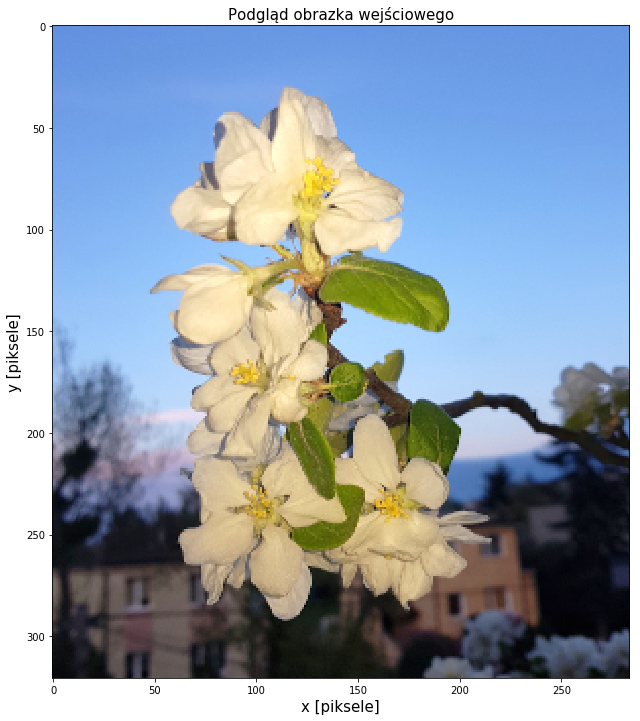

In [5]:
# Załadowanie obrazu wejściowego z dysku
image = Image.open("kwiat.jpg")

# Podgląd załadowanego obrazka:
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.xlabel('x [piksele]', fontsize=15)
plt.ylabel('y [piksele]', fontsize=15)
plt.title('Podgląd obrazka wejściowego', fontsize=15)

In [8]:
# Aby przeprowadzić proces segmentacji lub posteryzacji z wykorzystaniem algorytmu k średnich
# konieczne będzie skonwertowanie obrazka do postaci tabelki, która będzie zawierać indeks x i y
# każdego piksela, oraz wartości RGB reprezentujące jego kolor.

# Przygotowanie zmiennych x i y odpowiadających brzegowym wymiarom obrazka
x = np.arange(image.size[0])
y = np.arange(image.size[1])

# Wygenerowanie zmiennych xx oraz yy, które zawierać będą macierze 2D.
# współrzędne utworzone przez macierze 2D pozwalają zaadresować każdy piksel 
# z przetwarzanego obrazka.
xx,yy = np.meshgrid(x,y)

# Teraz tylko wystarczy "spłaszczyć" zmienne xx i yy, aby uzyskać listy indeksów
# wszystkich możliwych pikseli występujących w obrazku.
x_indices = xx.ravel()
y_indices = yy.ravel()

# Po przygotowaniu sobie listy "adresów" pikseli, wydzielimy osobno trzy kanały kolorów.
red, green, blue = image.split()

# Utworzymy pusty słownik, który będzie podstawą z której utworzona zostanie ramka danych
# do przetworzenia przez algorytm k średnich.
image_df= {}

# Najpierw do słownika zapiszemy tablice wszystkich indeksów pikseli z obrazka.
image_df.update({'x_indices':x_indices})
image_df.update({'y_indices':y_indices})

# Następnie dopiszemy 3 kolumny, które każdemu pikselowi zaadresowanemu przez dwie 
# poprzednie kolumny przypiszemy 3 wartości RGB
image_df.update({'vec_red': np.array(red)[y_indices, x_indices]})
image_df.update({'vec_green':np.array(green)[y_indices, x_indices]})
image_df.update({'vec_blue': np.array(blue)[y_indices, x_indices]})

# Na koniec konwertujemy słownik na obiekt DataFrame. Generujemy także zmienną data,
# która dane z ramki danych zawiera w postaci tablicy biblioteki NumPy - to na potrzeby
# algorytmu klasteryzacji.
image_df = pd.DataFrame(image_df)
data     = image_df.to_numpy()

# Jako ostatni krok - wyświetlimy podgląd danych w postaci tabelarycznej.
print('Podgląd danych w postaci tabelki:')
print(image_df)

Podgląd danych w postaci tabelki:
       x_indices  y_indices  vec_red  vec_green  vec_blue
0              0          0       99        145       223
1              1          0       97        143       221
2              2          0       98        144       222
3              3          0       99        145       223
4              4          0       99        145       223
...          ...        ...      ...        ...       ...
90555        278        319       25         24        29
90556        279        319       23         24        28
90557        280        319       25         26        30
90558        281        319       20         24        25
90559        282        319       20         22        21

[90560 rows x 5 columns]


Na początek warto sprawdzić, czy za pomocą analizy wykresu inercji w funkcji liczby klastrów możliwe jest określenie optymalnej wartości zmiennej $k$. Miejsce do uzupełnienia pozostawione jest w komórce poniżej. Uzupełnij ją bazując na kodzie z poprzednich przykładów. Jako, że obrazek jest dość dużych rozmiarów jak na szybkie ćwiczenie - uruchomienie algorytmu poszukiwania wartości $k$ może trwać kilkadziesiąt sekund.

In [27]:
# tutaj umieść kod odpowiedzialny za wybór wartości k

Gdy nastawa $k$ zostanie już wybrana, można przystąpić do implementacji algorytmu segmentacji obrazu. Miejsce na implementacje pozostawione jest w komórce poniżej. Klasteryzacji poddaj dane w zmiennej *data*. Następnie utwórz pustą tablicę na nowy, przetworzony obrazek (np. funkcją np.zeros). Powinna mieć dwa pierwsze wymiary takie jak obrazek wejściowy oraz trzeci wymiar o długości 3, aby zapisać tam wartości RGB. Potem wystarczy przeiterować się po wszystkich unikalnych wartościach klas i za pomocą maski przypisać do indeksów odpowiadających poszczególnym pikselom obrazka (tutaj przyda się zmienna image_df) uśredniony kolor klastra. Kolor można obliczyć także za pomocą maski i np. za pomocą funkcji np.mean dostępnej w bibliotece NumPy. Na koniec wyświetl tak przygotowaną tablicę poleceniem plt.imshow

In [26]:
# tutaj umieść implementację algorytmu

# Zadania do wykonania

## Zadanie 1.
Zaimplementuj brakujące fragmenty kodu w wyznaczonych miejscach skryptu. Następnie uruchom algorytm k średnich. Powinien on jako wejście przyjmować ramkę DataFrame z danymi (kod ją przygotowujący jest już napisany, zawiera ona współrzędne x,y pikseli oraz ich kolory w formacie RGB) i dokonujący klasteryzacji znajdujących się w niej punktów. Następnie dla każdego klastra powinien zostać policzony uśredniony kolor RGB punktów w nim się znajdujących. Na koniec powinien zostać utworzony nowy obrazek, w którym punkty należące do każego klastra będą pokolorowane średnim kolorem klastra. Spowoduje to powstanie efektu, który czasami bywa nazywany posteryzacją.
<ol>
    <li/> Jaki wizualny efekt powoduje wykonanie algorytmu k średnich na przetwarzanym obrazku? 
    <li/> Pomyśl o możliwych zastosowaniach efektu zaprogramowanego w trakcie ćwiczenia. Na laboratorium zaimplementowaliśmy go aby zapoznać się z tym, w jaki sposób algorytm k średnich może służyć do przetwarzania obrazów. Czy jesteś w stanie wskazać jakieś praktyczne zastosowania dla takiego przetwarzania obrazów, jak to zaprezentowane w przykładzie? 
</ol>

Jeśli nie wiesz, jak zaimplementować algorytm opisany w zadaniu, zapoznaj się z Dodatkiem A., który zawiera zestaw podpowiedzi odnośnie tego, jak można zrealizować takie zadanie.

# Dodatek - wskazówki dotyczące implementacji algorytmu w zadaniu<br/>(dla osób początkujących z programowania w Pythonie)

<p>Jeśli jeszcze nie czujesz się pewnie jeśli chodzi o pisanie oprogramowania w języku Python i nie do końca wiesz, jak zaimplementować algorytm w tym przykładzie, to ten dodatek zawiera kilka dodatkowych wskazówek. Jeżli jesteś osobą zaawansowaną, możesz chcieć najpierw spróbować zaimplementować algorytm samodzielnie, a następnie dopiero zajrzeć do tej sekcji instrukcji.</p>

Klaster 1
   x  y    r    g    b
0  0  0  120  200   80
1  1  0  120  200   80
2  2  0  120  180  120
8  2  2  140  200   80

Klaster 2
   x  y    r    g    b
3  0  1  120  180  120
4  1  1  140  180  200
5  2  1  140  180  200
6  0  2  140  200   80
7  1  2  140  200  120

średnia wartość czerwieni w klastrze 2: 136.0


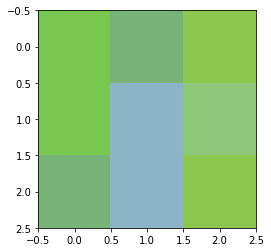

In [4]:
# "Miniaturowa" wersja problemu do rozwiązania w zadaniu już w postaci struktury DataFrame
df = pd.DataFrame({
'x':[0,1,2,0,1,2,0,1,2], # współrzędne pikseli
'y':[0,0,0,1,1,1,2,2,2],
'r':[120,120,120,120,140,140,140,140,140], # wartości koloru RGB pikseli
'g':[200,200,180,180,180,180,200,200,200],
'b':[80,80,120,120,200,200,80,120,80],
})

# Przykładowy podział na klastry (docelowo wygenerowany przez algorytm k średnich)
clusters = np.array([1,1,1,2,2,2,2,2,1])
# każdy z pikseli dostał przydział do jednego z 2 klastrów (zakładamy, że k=2)
# jako, że mamy 9 pikseli, to także tutaj mamy 9 wartości przypisujących piksele
# do jednego z 2 klastrów

# Możemy sobie wybierać wiersze z struktury DataFrame w ten sposób:
mask = clusters==1 # schemat wyboru zapisujemy sobie w osobnej zmiennej, dla wygody nazwijmy ją "maską"
print('Klaster 1')
print(df.loc[mask,:])

print()

# Dla drugiego klastra:
mask = clusters==2
print('Klaster 2')
print(df.loc[mask,:])

# Po wyświetleniu nawet widać w rezultacie w konsoli (po indeksie), że  pandas zgodnie z maską wybrał wiersze 
# tabeli odpowiadające wartościom 1 i 2 w zmiennej clusters.

# Średni kolor klastra można policzyć uśredniając kolumny po takim wyborze odpowiadających wierszy,
# poniżej przykład dla koloru czerwonego.
mean_red = np.mean(df.loc[mask,'r'])

print()
print(f'średnia wartość czerwieni w klastrze 2: {mean_red}')

# Warto sobie porównać wyświetloną wartość uśrednionego czerwonego z wartościami w klastrze 2, 
# widać że się zgadza.

# A jak wyświetlić taki "spłaszczony" obrazek przechowywany w strukturze DataFrame?
# Na początek trzeba sobie zarezerwować pustą tablicę. Ze zmiennych x i y wychodzi, że obrazek jest rozmiarów
# 3x3. Dodatkowo musimy dodać jeszcze jeden wymiar o długości 3, bo potrzebujemy tam zapisać kolor w formacie RGB.
image = np.zeros((3,3,3))

# Upewniamy się, że tablica ma typ int, bo inaczej imshow jej nie wyświetli (jak wartości 0-255 to używamy intów,
# alternatywnie możemy też stosować floaty od 0 do 1).
image = image.astype(int)

# Teraz starczy tylko odpowiednim indeksom przypisać kolory, bo w zmiennej df jest kompletny przepis
# na obrazek (współrzędne x,y, i kolory rgb).

# Ustawiamy czerwienie w odpowiadających im punktach obrazka:
image[df.loc[:,'x'],df.loc[:,'y'],0] = df.loc[:,'r']

# Zielenie:
image[df.loc[:,'x'],df.loc[:,'y'],1] = df.loc[:,'g']

# i kolor niebieski:
image[df.loc[:,'x'],df.loc[:,'y'],2] = df.loc[:,'b']

# To jest tylko przykład dla odzyskania oryginalnego obrazka z ramki pandasa, nie pokazuje on mechanizmju 
# uśredniania koloru w poszczególnych klastrach wyróżnionych przez algorytm k średnich.
# Można to prosto policzyć poprzez wybranie odpowiednich punktów i użycie funkcji np.mean()
plt.imshow(image)

![stopka.svg](stopka.svg)